In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape,UpSampling2D,  Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation, Dropout,ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as k
from tensorflow.keras.optimizers import RMSprop



import numpy as np
import matplotlib.pyplot as plt

(x_train,_), (_,_)=mnist.load_data()
x_train=np.reshape(x_train, [-1,x_train.shape[1],x_train.shape[1],1])
x_train=(x_train.astype('float32')-127.5)/127.5
print(x_train.shape)
print(np.max(x_train),np.min(x_train))
model_name='wgan_mnist'
latent_dim=100
n_critic=5
clip_value=0.01
batch_size=32
train_steps=40000

def wasserstein_loss(y_label,y_pred):
    return -k.mean(y_label*y_pred)

Using TensorFlow backend.


(60000, 28, 28, 1)
1.0 -1.0


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 32)          0   

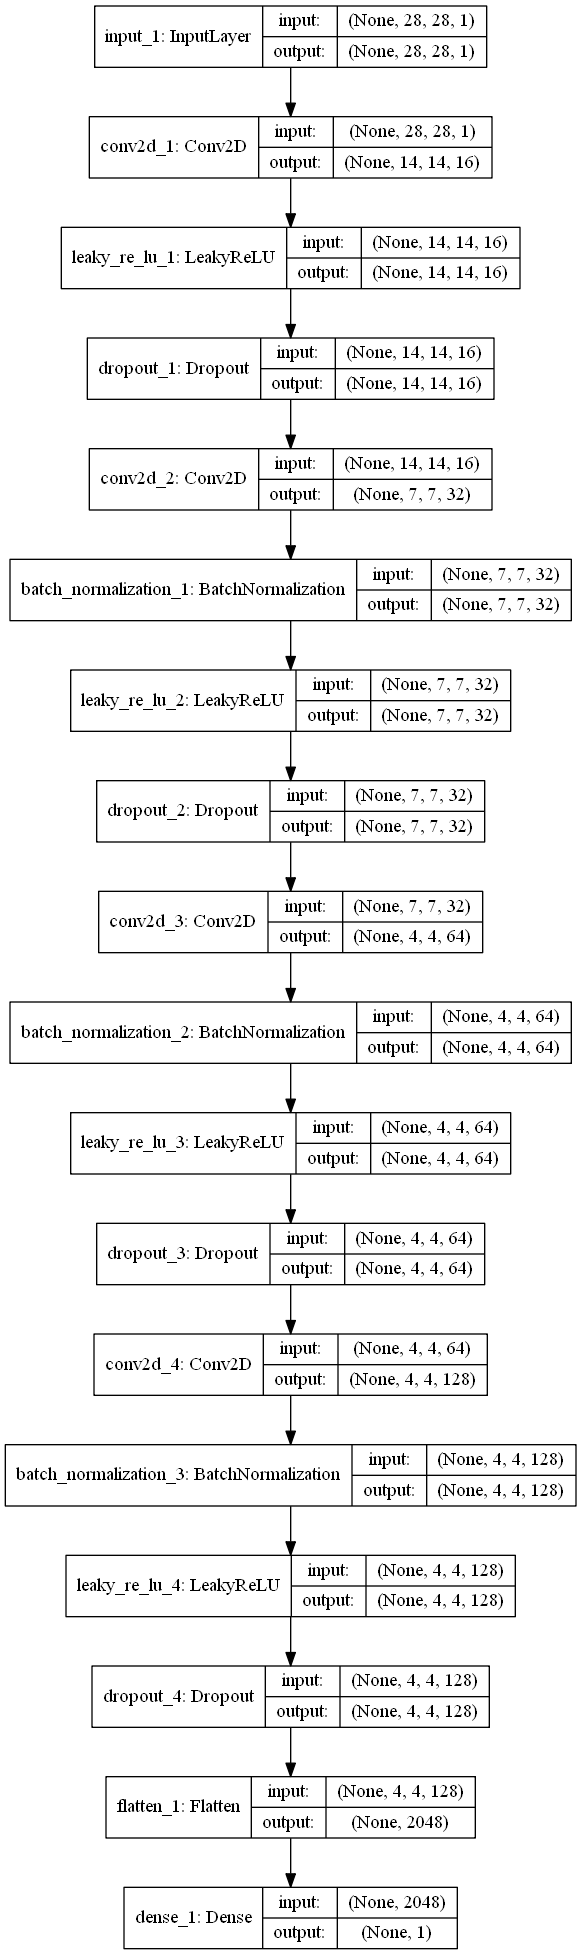

In [2]:
img_size=x_train.shape[1]
input_d=Input(shape=(img_size,img_size,1))
x=Conv2D(16,3,strides=2,padding='same')(input_d)
x=LeakyReLU(alpha=0.2)(x)
x=Dropout(0.25)(x)
x=Conv2D(32,3,strides=2,padding='same')(x)
x=BatchNormalization(momentum=0.8)(x)
x=LeakyReLU(alpha=0.2)(x)#default는 0.3
x=Dropout(0.25)(x)
x=Conv2D(64,3,strides=2,padding='same')(x)
x=BatchNormalization(momentum=0.8)(x)
x=LeakyReLU(alpha=0.2)(x)
x=Dropout(0.25)(x)
x=Conv2D(128,3,strides=1,padding='same')(x)
x=BatchNormalization(momentum=0.8)(x)
x=LeakyReLU(alpha=0.2)(x)
x=Dropout(0.25)(x)
x=Flatten()(x)
out_d=Dense(1)(x)
discriminator=Model(input_d,out_d)

discriminator.compile(loss=wasserstein_loss, optimizer=RMSprop(lr=0.00005), metrics=['acc'])
discriminator.summary()
plot_model(discriminator, show_shapes=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        1311

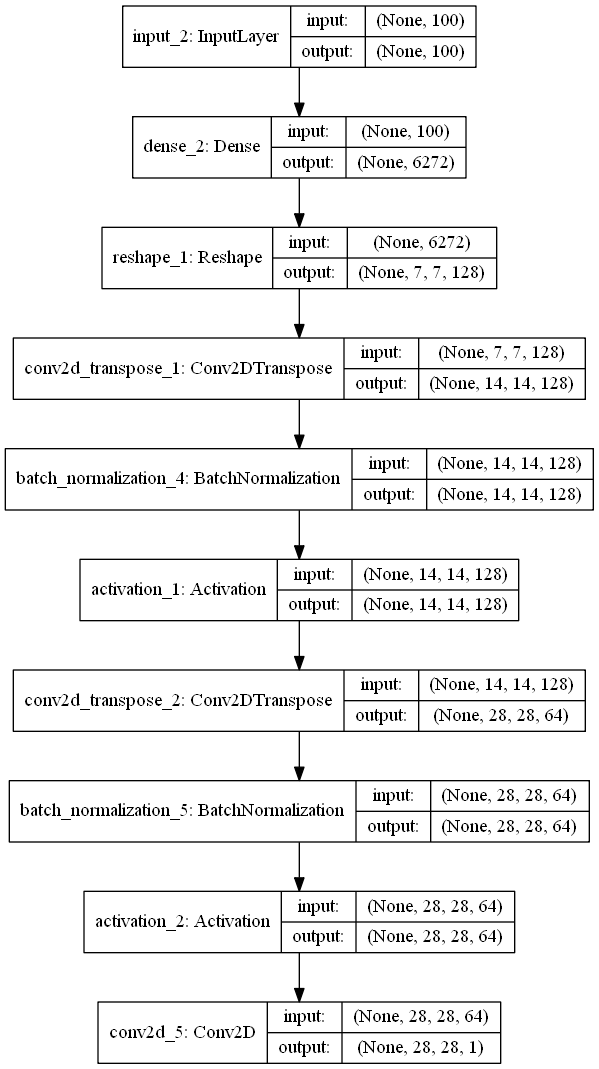

In [3]:
input_g=Input(shape=(latent_dim,))
x=Dense(7*7*128)(input_g)
x=Reshape((7,7,128))(x)
x=Conv2DTranspose(128,4,strides=2,padding='same')(x)
x=BatchNormalization(momentum=0.8)(x)
x=Activation('relu')(x)
x=Conv2DTranspose(64,4,strides=2,padding='same')(x)
x=BatchNormalization(momentum=0.8)(x)
x=Activation('relu')(x)
out_g=Conv2D(1,4,padding='same',activation='tanh')(x)
generator=Model(input_g,out_g)
generator.summary()
plot_model(generator,show_shapes=True)

Model: "wgan_mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         1028673   
_________________________________________________________________
model_1 (Model)              (None, 1)                 100097    
Total params: 1,128,770
Trainable params: 1,028,289
Non-trainable params: 100,481
_________________________________________________________________


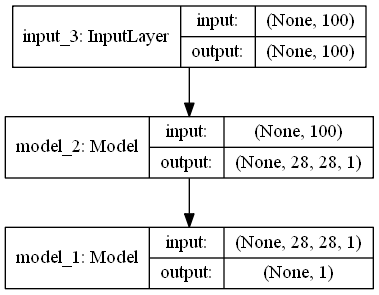

In [4]:
z=Input(shape=(latent_dim,))
img=generator(z)
discriminator.trainable=False
valid=discriminator(img)
adversarial=Model(z,valid,name=model_name)
adversarial.compile(loss=wasserstein_loss, optimizer=RMSprop(lr=0.00005),metrics=['acc'])
adversarial.summary()
plot_model(adversarial,show_shapes=True)

C:\Users\ysp\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\ysp\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\ysp\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000:(discriminator loss:0.000029):[adversarial loss:-0.000062]


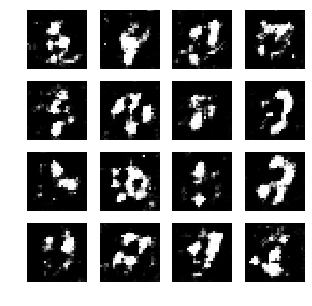

2000:(discriminator loss:0.000029):[adversarial loss:-0.000061]


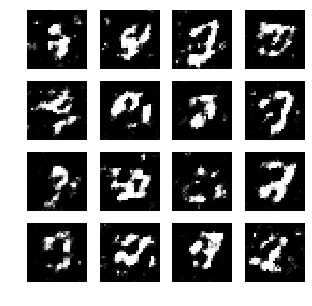

3000:(discriminator loss:0.000028):[adversarial loss:-0.000061]


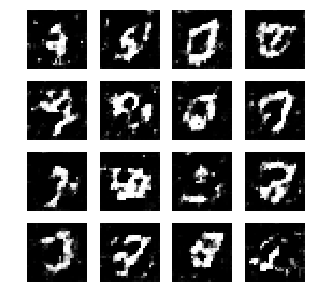

4000:(discriminator loss:0.000028):[adversarial loss:-0.000069]


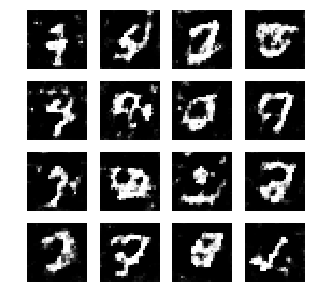

5000:(discriminator loss:0.000031):[adversarial loss:-0.000055]


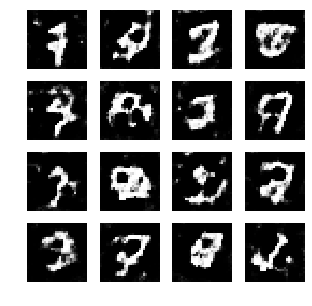

6000:(discriminator loss:0.000027):[adversarial loss:-0.000059]


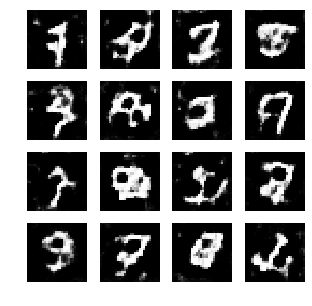

7000:(discriminator loss:0.000038):[adversarial loss:-0.000078]


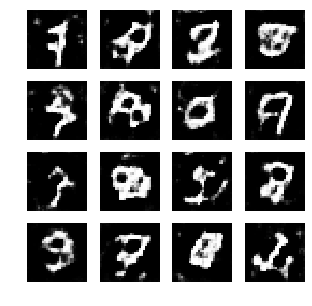

8000:(discriminator loss:0.000030):[adversarial loss:-0.000056]


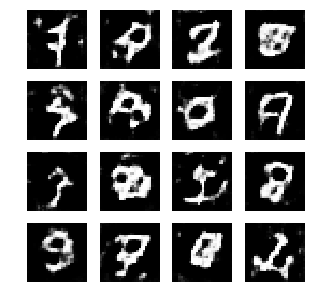

9000:(discriminator loss:0.000030):[adversarial loss:-0.000067]


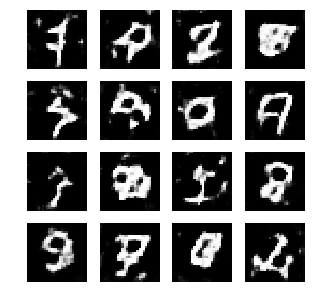

10000:(discriminator loss:0.000031):[adversarial loss:-0.000053]


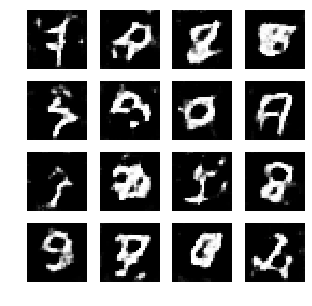

11000:(discriminator loss:0.000031):[adversarial loss:-0.000048]


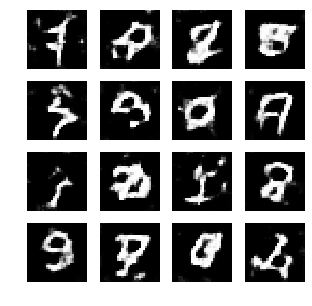

12000:(discriminator loss:0.000023):[adversarial loss:-0.000078]


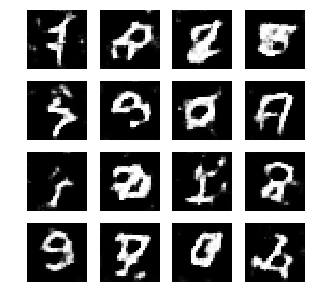

13000:(discriminator loss:0.000027):[adversarial loss:-0.000048]


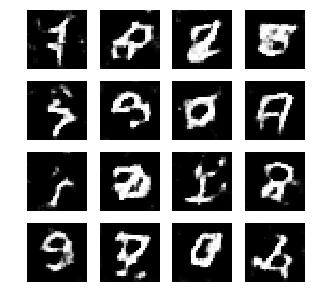

14000:(discriminator loss:0.000025):[adversarial loss:-0.000078]


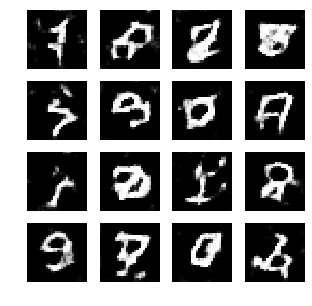

15000:(discriminator loss:0.000029):[adversarial loss:-0.000077]


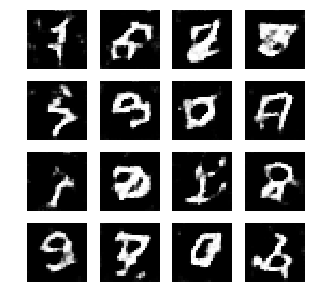

16000:(discriminator loss:0.000035):[adversarial loss:-0.000057]


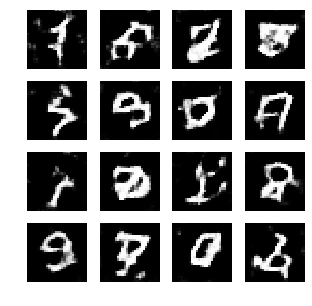

17000:(discriminator loss:0.000038):[adversarial loss:-0.000062]


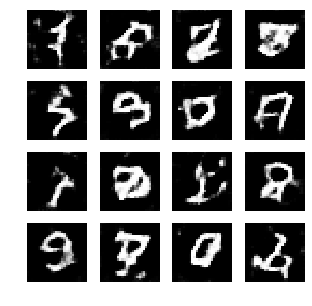

18000:(discriminator loss:0.000033):[adversarial loss:-0.000066]


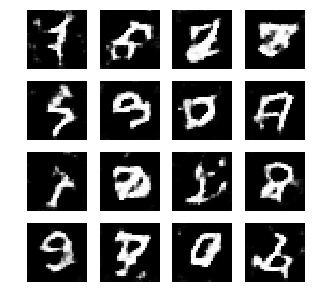

19000:(discriminator loss:0.000029):[adversarial loss:-0.000069]


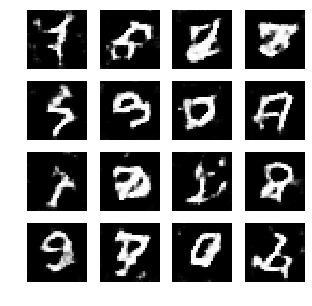

20000:(discriminator loss:0.000028):[adversarial loss:-0.000070]


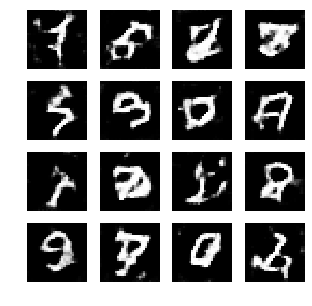

21000:(discriminator loss:0.000035):[adversarial loss:-0.000067]


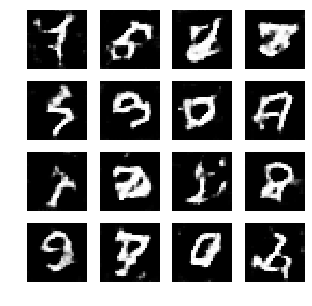

22000:(discriminator loss:0.000029):[adversarial loss:-0.000058]


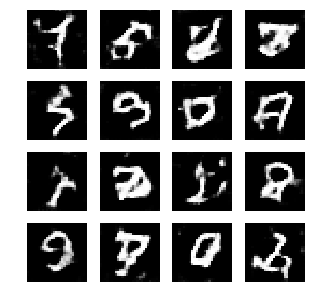

23000:(discriminator loss:0.000032):[adversarial loss:-0.000065]


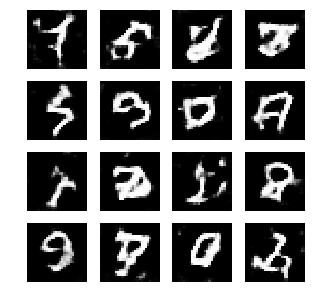

24000:(discriminator loss:0.000027):[adversarial loss:-0.000059]


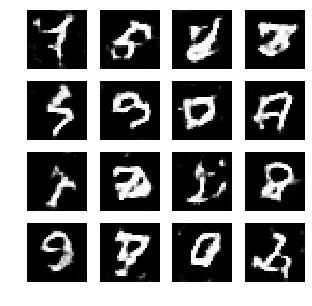

25000:(discriminator loss:0.000027):[adversarial loss:-0.000063]


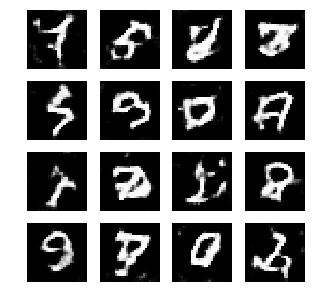

26000:(discriminator loss:0.000032):[adversarial loss:-0.000065]


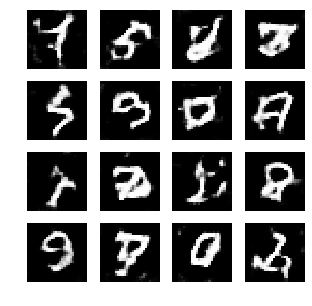

27000:(discriminator loss:0.000029):[adversarial loss:-0.000068]


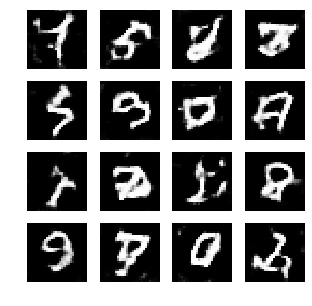

28000:(discriminator loss:0.000030):[adversarial loss:-0.000065]


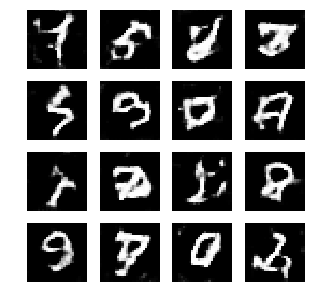

29000:(discriminator loss:0.000028):[adversarial loss:-0.000074]


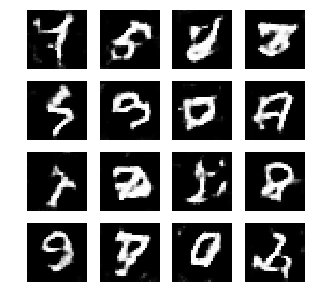

30000:(discriminator loss:0.000025):[adversarial loss:-0.000068]


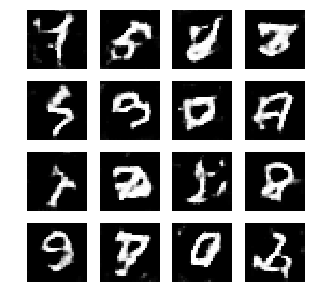

31000:(discriminator loss:0.000027):[adversarial loss:-0.000077]


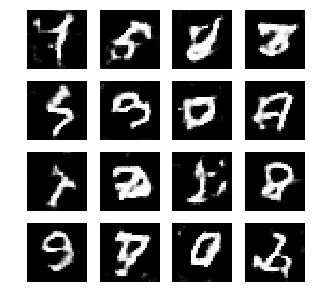

32000:(discriminator loss:0.000031):[adversarial loss:-0.000058]


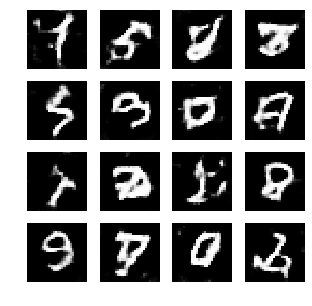

33000:(discriminator loss:0.000023):[adversarial loss:-0.000071]


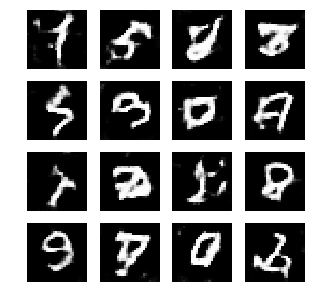

34000:(discriminator loss:0.000028):[adversarial loss:-0.000077]


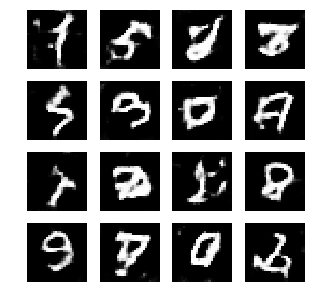

35000:(discriminator loss:0.000030):[adversarial loss:-0.000059]


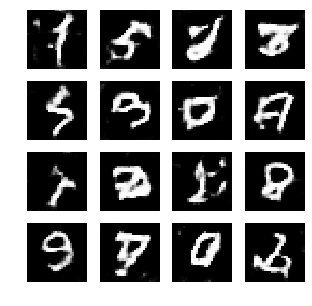

36000:(discriminator loss:0.000025):[adversarial loss:-0.000077]


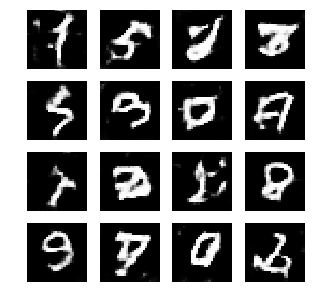

37000:(discriminator loss:0.000029):[adversarial loss:-0.000068]


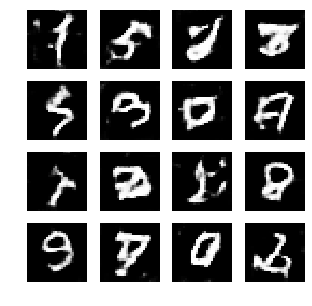

38000:(discriminator loss:0.000032):[adversarial loss:-0.000073]


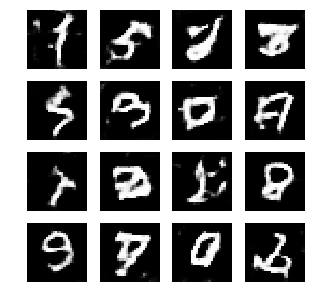

39000:(discriminator loss:0.000029):[adversarial loss:-0.000065]


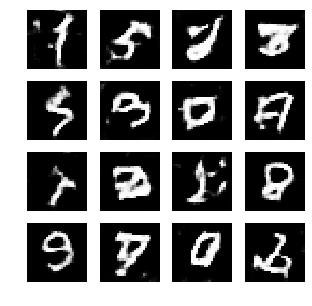

40000:(discriminator loss:0.000031):[adversarial loss:-0.000069]


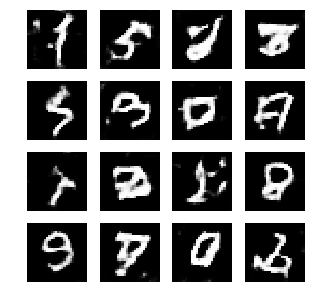

In [5]:
show_interval=1000
noise_input=np.random.normal(0,1,size=[16,latent_dim])
real_labels=np.ones((batch_size,1))
fake_labels=-np.ones((batch_size,1))
for i in range(train_steps):
    loss=0
    for _ in range(n_critic):
        rand_index=np.random.randint(0,x_train.shape[0],size=batch_size)
        real_images=x_train[rand_index]
        noise=np.random.normal(0,1,size=[batch_size,latent_dim])
        fake_images=generator.predict(noise)
        real_loss, real_acc=discriminator.train_on_batch(real_images,real_labels)
        fake_loss, fake_acc=discriminator.train_on_batch(fake_images,fake_labels)
        loss+=0.5*(real_loss+fake_loss)
        
        for layer in discriminator.layers:
            weights=layer.get_weights()
            weights=[np.clip(w,-clip_value,clip_value) for w in weights]
            layer.set_weights(weights)
    loss/=n_critic
    log_d='%d:(discriminator loss:%f)' %((i+1),loss)
    noise=np.random.normal(0.,1,size=[batch_size,latent_dim])
    loss=adversarial.train_on_batch(noise,real_labels)
    log='%s:[adversarial loss:%f]' %(log_d,loss[0])
   
    if (i+1)%show_interval==0:
        print(log)
        rows=int(np.sqrt(noise_input.shape[0]))
        images=generator.predict(noise_input)
        images=0.5*images+0.5
        plt.figure(figsize=(5,5))
        num_images=images.shape[0]
        image_size=images.shape[1]
        for j in range(num_images):
            plt.subplot(rows,rows,j+1)
            image=np.reshape(images[j],[image_size,image_size])
            plt.imshow(image,cmap='gray')
            plt.axis('off')
        plt.show()